<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_CC50_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и подготовка данных:

In [ ]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                             GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.base import clone
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Метрики
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)

import joblib
from pickle import TRUE
import os
import optuna

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade_df = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['IC50', 'SI'])
pca_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'pca_cleaned_CC50.csv'))
tsne_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_CC50.csv'))
umap_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'umap_cleaned_CC50.csv'))

In [ ]:
# @title Подготовка данных для моделирования
# подготовка данных для handmade_df
median = []
median = handmade_df['CC50'].median()
handmade_df['target'] = (handmade_df['CC50'] > median).astype(int)
X1 = handmade_df.drop(columns=['CC50', 'target'])
y1 = handmade_df['target']
dataframe_name_1 = 'df_handmade'
metod_name_1 = 'df_handmade'
csv_file_1 = 'results_handmade_df_CC50_classification.csv'

# подготовка данных для pca_cleaned_CC50
median = []
median = pca_cleaned_CC50['CC50'].median()
pca_cleaned_CC50['target'] = (pca_cleaned_CC50['CC50'] > median).astype(int)
X2 = pca_cleaned_CC50.drop(columns=['CC50', 'target'])
y2 = pca_cleaned_CC50['target']
dataframe_name_2 = 'cleaned_CC50'
metod_name_2 = 'PCA'
csv_file_2 = 'results_pca_cleaned_CC50_classification.csv'

# подготовка данных для tsne_cleaned_CC50
median = []
median = tsne_cleaned_CC50['CC50'].median()
tsne_cleaned_CC50['target'] = (tsne_cleaned_CC50['CC50'] > median).astype(int)
X3 = tsne_cleaned_CC50.drop(columns=['CC50', 'target'])
y3 = tsne_cleaned_CC50['target']
dataframe_name_3 = 'cleaned_CC50'
metod_name_3 = 'tSNE'
csv_file_3 = 'results_tsne_cleaned_CC50_classification.csv'

# подготовка данных для umap_cleaned_CC50
median = []
median = umap_cleaned_CC50['CC50'].median()
umap_cleaned_CC50['target'] = (umap_cleaned_CC50['CC50'] > median).astype(int)
X4 = umap_cleaned_CC50.drop(columns=['CC50', 'target'])
y4 = umap_cleaned_CC50['target']
dataframe_name_4 = 'cleaned_CC50'
metod_name_4 = 'UMAP'
csv_file_4 = 'results_umap_cleaned_CC50_classification.csv'

# название файла с хранением всех результатов
csv_file_final = 'class_results_CC50.csv'

# МОДЕЛИРОВАНИЕ

In [ ]:
# @title класс ClassificationModelEvaluator для анализа моделей
class ClassificationModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        """Инициализация класса для оценки классификационных моделей"""
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = None
        self.best_model = None

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        self._initialize_models()

    def _initialize_models(self):
        """Инициализация моделей с параметрами"""
        self.models = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(max_iter=2000)
                ),
                'params': {
                    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logisticregression__penalty': ['l2'],
                    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
                }
            },
            'SVC': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVC(probability=True)
                ),
                'params': {
                    'svc__C': [0.1, 1, 10],
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
            },
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsClassifier()
                ),
                'params': {
                    'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsclassifier__weights': ['uniform', 'distance'],
                    'kneighborsclassifier__p': [1, 2]
                }
            },
            'DecisionTree': {
                'model': DecisionTreeClassifier(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'depth': [3, 5, 7, 10],
                    'l2_leaf_reg': [3, 5]
                }
            }
        }

    def evaluate_models(self, verbose=False):
        """Оценка всех моделей с подбором гиперпараметров"""
        results = []

        for name, model_info in self.models.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Processing {name}...")

            model = model_info['model']
            params = model_info['params']

            # Подбор параметров через GridSearchCV
            gs = GridSearchCV(
                model,
                params,
                cv=5,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1
            )
            gs.fit(self.X_train, self.y_train)

            # Лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = gs.best_score_

            if verbose:
                print(f"Best params: {best_params}")

            # Предсказания
            y_pred = best_model.predict(self.X_test)
            y_proba = best_model.predict_proba(self.X_test)[:, 1]

            # Метрики
            metrics = {
                'Model': name,
                'Best Parameters': best_params,
                'CV ROC AUC': cv_score,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }

            results.append(metrics)

            if verbose:
                print(f"Completed: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")

            # Сохраняем лучшую модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (best_model, metrics['Test ROC AUC'])

        # Сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)

        return self.results

    def get_best_model(self):
        """Возвращает лучшую модель с метриками"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        return self.best_model[0]

    def predict(self, X, return_proba=False):
        """Предсказание с использованием лучшей модели"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

    def get_feature_importances(self):
        """Возвращает важность признаков для моделей, где это применимо"""
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        model = self.best_model[0]

        if hasattr(model, 'feature_importances_'):
            # Для ансамблевых моделей и деревьев
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Для линейных моделей
            importances = model.coef_[0]
        else:
            raise ValueError("Модель не поддерживает атрибут важности признаков")

        return pd.DataFrame({
            'Feature': self.X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        """
        Сохраняет указанную модель в файл
        """
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")

        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)

        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")

            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

In [ ]:
# @title Класс ClassificationResultsVisualizer для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np

class ClassificationResultsVisualizer:
    def __init__(self, evaluator, results_df):
        self.evaluator = evaluator
        self.results_df = results_df
        self.best_model_name = results_df.index[0]

        # Настройка стиля графиков
        sns.set_style("whitegrid")
        self.colors = sns.color_palette("husl")
        plt.rcParams['figure.facecolor'] = 'white'

    def plot_metrics_comparison(self, metrics=None, ax=None):
        if metrics is None:
            metrics = ['Test ROC AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']

        plot_df = self.results_df[metrics].sort_values(metrics[0], ascending=True)
        colors = self.colors[:len(metrics)]
        plot_df.plot(kind='barh', width=0.8, color=colors, ax=ax, legend=False)    # выключили легенду

        ax.set_title('Сравнение метрик', fontsize=13)
        ax.set_xlabel('Значение метрики', fontsize=11)
        ax.set_ylabel('Модель', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(metrics, loc='lower right', fontsize=8)

    def plot_roc_curves(self, top_n=10, ax=None):
        for i, model_name in enumerate(self.results_df.index[:top_n]):
            roc_auc = self.results_df.loc[model_name, 'Test ROC AUC']
            model_info = self.evaluator.models[model_name]
            model = model_info['model'].fit(self.evaluator.X_train, self.evaluator.y_train)
            y_proba = model.predict_proba(self.evaluator.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.evaluator.y_test, y_proba)
            ax.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.2f})',
                    color=self.colors[i % len(self.colors)])
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title(f'ROC-кривые топ-{top_n} моделей', fontsize=13)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def plot_confusion_matrix(self, ax=None):
        best_model_pred = self.evaluator.predict(self.evaluator.X_test)
        cm = confusion_matrix(self.evaluator.y_test, best_model_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Низкий IC50', 'Высокий IC50'],
                    yticklabels=['Низкий IC50', 'Высокий IC50'],
                    ax=ax)
        ax.set_title(f'Матрица ошибок ({self.best_model_name})', fontsize=13)
        ax.set_ylabel('Истинный класс', fontsize=11)
        ax.set_xlabel('Предсказанный класс', fontsize=11)

    def plot_precision_recall_curve(self, ax=None):
        y_proba = self.evaluator.predict(self.evaluator.X_test, return_proba=True)[:, 1]
        precision, recall, _ = precision_recall_curve(self.evaluator.y_test, y_proba)
        average_precision = average_precision_score(self.evaluator.y_test, y_proba)
        ax.plot(recall, precision, color=self.colors[2], lw=2,
                label=f'AP = {average_precision:.2f}')
        ax.set_xlabel('Recall', fontsize=11)
        ax.set_ylabel('Precision', fontsize=11)
        ax.set_title(f'Precision-Recall кривая ({self.best_model_name})', fontsize=13)
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def visualize_all(self):
        # 2 строки, 2 столбца
        fig, axes = plt.subplots(2, 2, figsize=(17, 13))
        plt.subplots_adjust(hspace=0.3, wspace=0.2)

        self.plot_metrics_comparison(ax=axes[0, 0])
        self.plot_roc_curves(ax=axes[0, 1])
        self.plot_confusion_matrix(ax=axes[1, 0])
        self.plot_precision_recall_curve(ax=axes[1, 1])

        plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


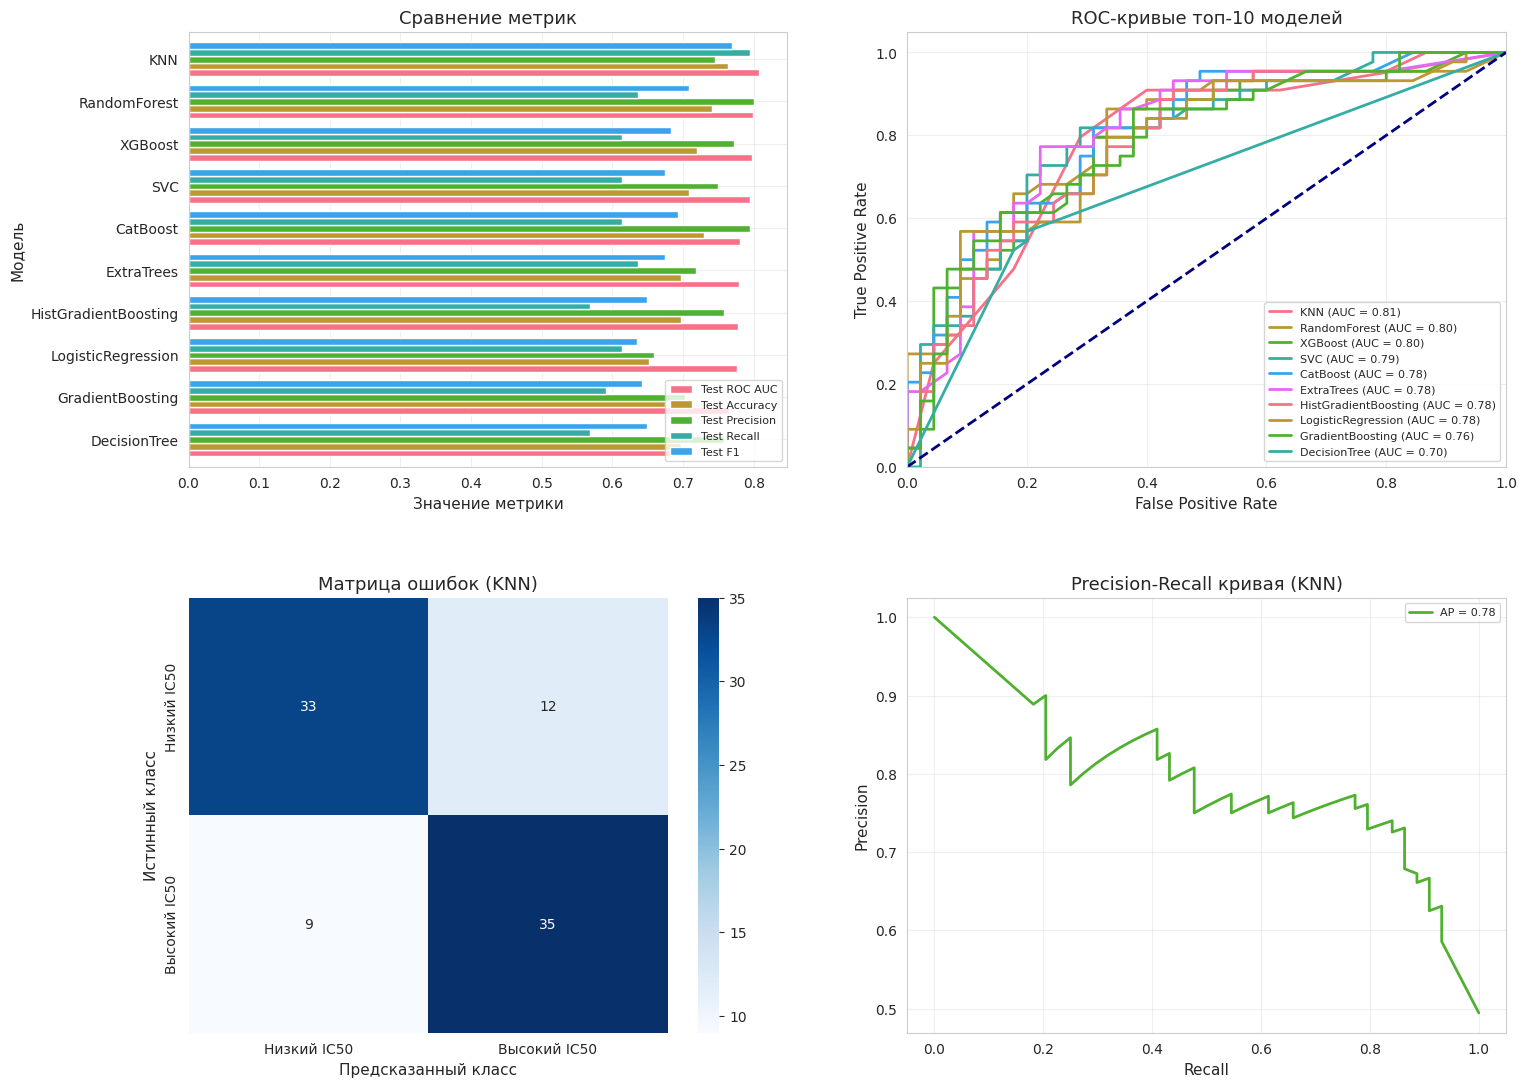

In [ ]:
# @title Тест моделей на ручных данных
# Инициализация
evaluator_handmade_df = ClassificationModelEvaluator(X1, y1, test_size=0.2)

# Оценка моделей
results = evaluator_handmade_df.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade_df = results.copy()
results_handmade_df['dataframe'] = dataframe_name_1
results_handmade_df['metod'] = metod_name_1
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_handmade_df = results_handmade_df[columns_order]

# Получение лучшей модели
best_model = evaluator_handmade_df.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_handmade_df.predict(X1)
predictions_handmade_df = predictions

# Сохраненние результата
results_handmade_df_id = results_handmade_df.reset_index()
results_handmade_df_id.to_csv(os.path.join(data_dir, csv_file_1), index=False)

# Диаграмки
visualizer = ClassificationResultsVisualizer(evaluator_handmade_df, results_df = results_handmade_df)
visualizer.visualize_all()

In [ ]:
results_handmade_df.head(5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


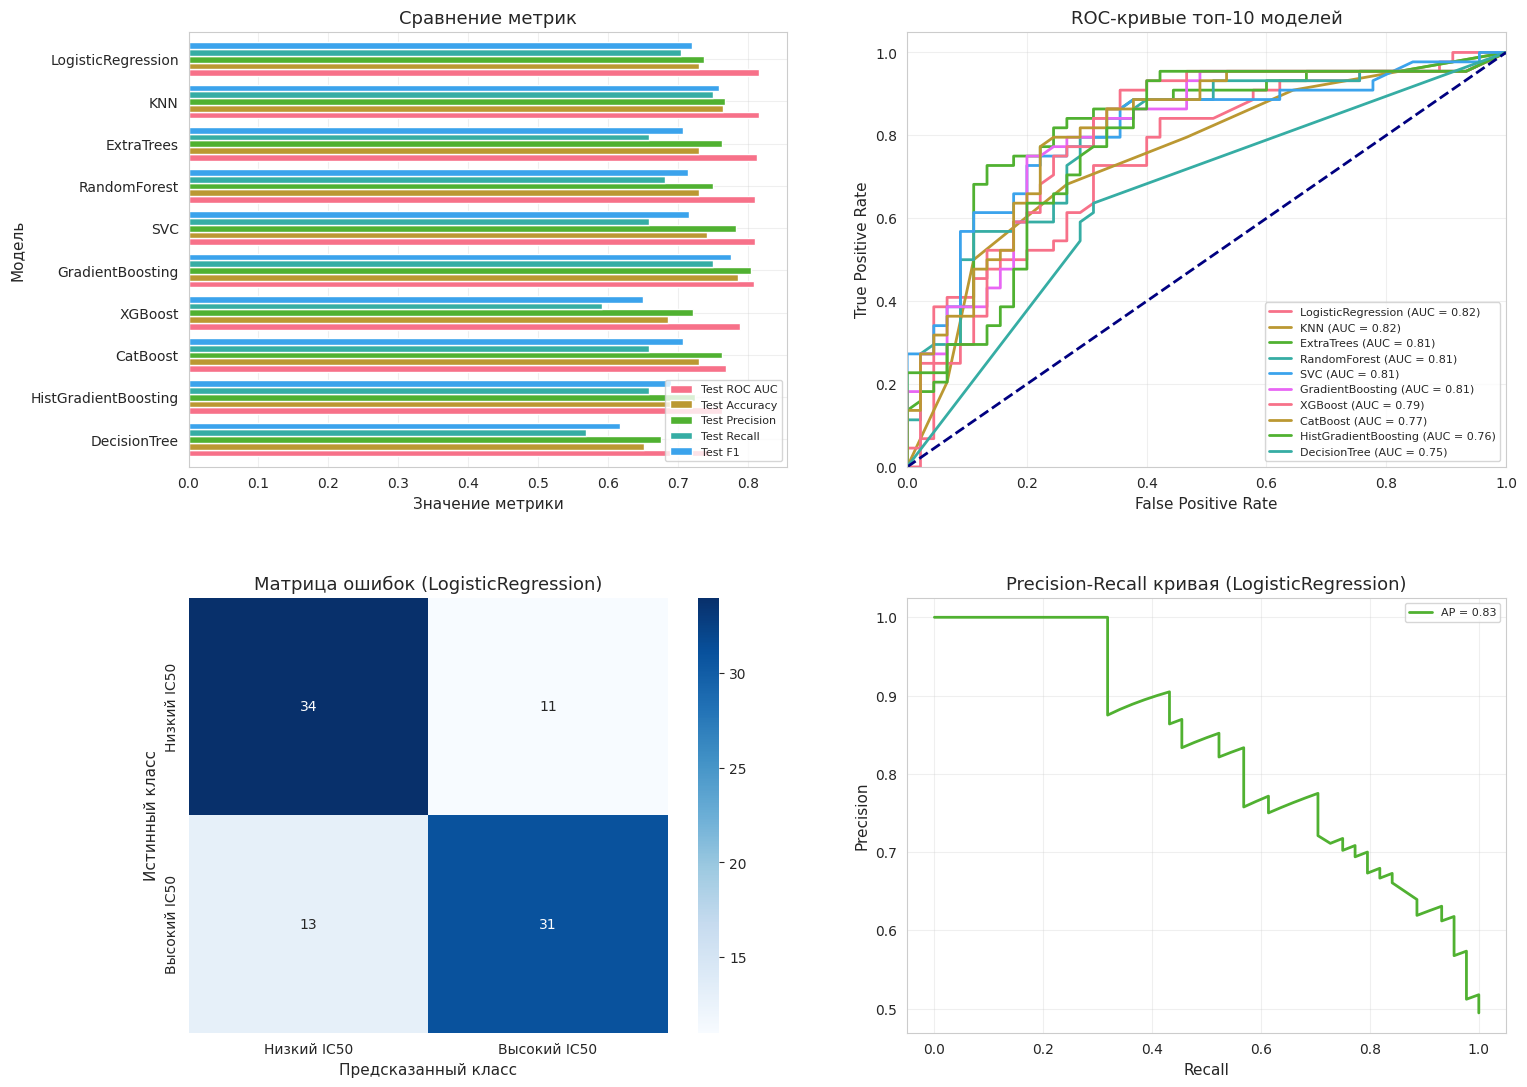

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных PCA(50 параметров)
# Инициализация
evaluator_pca_cleaned = ClassificationModelEvaluator(X2, y2, test_size=0.2)

# Оценка моделей
results = evaluator_pca_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_pca_cleaned = results.copy()
results_pca_cleaned['dataframe'] = dataframe_name_2
results_pca_cleaned['metod'] = metod_name_2
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_pca_cleaned = results_pca_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_pca_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_pca_cleaned.predict(X2)
predictions_pca_cleaned = predictions

# Сохраненние результата
results_pca_cleaned_id = results_pca_cleaned.reset_index()
results_pca_cleaned_id.to_csv(os.path.join(data_dir, csv_file_2), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_pca_cleaned, results_df = results_pca_cleaned)
visualizer.visualize_all()

In [ ]:
results_pca_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
LogisticRegression,cleaned_CC50,PCA,"{'logisticregression__C': 0.001, 'logisticregr...",0.769939,0.730337,0.738095,0.704545,0.720930,0.815909,"[[34, 11], [13, 31]]","{'0': {'precision': 0.723404255319149, 'recall..."
KNN,cleaned_CC50,PCA,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.785422,0.764045,0.767442,0.750000,0.758621,0.815909,"[[35, 10], [11, 33]]","{'0': {'precision': 0.7608695652173914, 'recal..."
ExtraTrees,cleaned_CC50,PCA,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.785331,0.730337,0.763158,0.659091,0.707317,0.813384,"[[36, 9], [15, 29]]","{'0': {'precision': 0.7058823529411765, 'recal..."
RandomForest,cleaned_CC50,PCA,"{'max_depth': 7, 'max_features': 'sqrt', 'min_...",0.789304,0.730337,0.750000,0.681818,0.714286,0.810354,"[[35, 10], [14, 30]]","{'0': {'precision': 0.7142857142857143, 'recal..."
SVC,cleaned_CC50,PCA,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.790941,0.741573,0.783784,0.659091,0.716049,0.809848,"[[37, 8], [15, 29]]","{'0': {'precision': 0.7115384615384616, 'recal..."


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


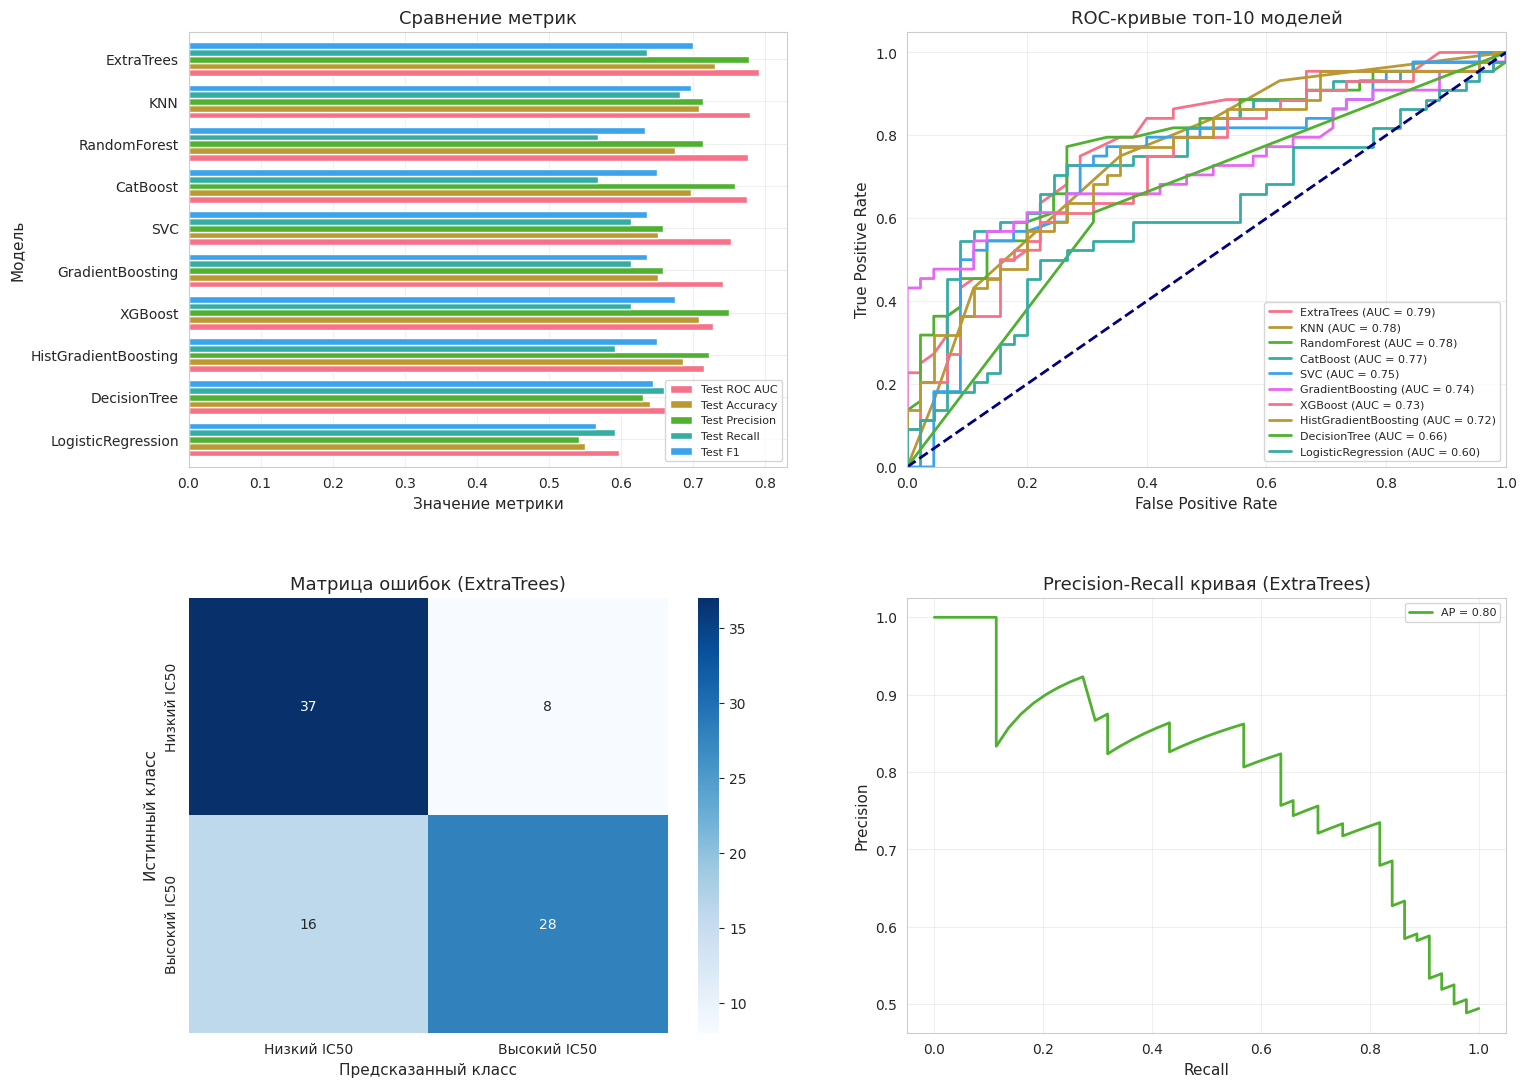

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSNE
# Инициализация
evaluator_tsne_cleaned = ClassificationModelEvaluator(X3, y3, test_size=0.2)

# Оценка моделей
results = evaluator_tsne_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_tsne_cleaned = results.copy()
results_tsne_cleaned['dataframe'] = dataframe_name_3
results_tsne_cleaned['metod'] = metod_name_3
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_tsne_cleaned = results_tsne_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_tsne_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_tsne_cleaned.predict(X3)
predictions_tsne_cleaned = predictions

# Сохраненние результата
results_tsne_cleaned_id = results_tsne_cleaned.reset_index()
results_tsne_cleaned_id.to_csv(os.path.join(data_dir, csv_file_3), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_tsne_cleaned, results_df = results_tsne_cleaned)
visualizer.visualize_all()

In [ ]:
results_tsne_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
ExtraTrees,cleaned_CC50,tSNE,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.751288,0.730337,0.777778,0.636364,0.700000,0.791162,"[[37, 8], [16, 28]]","{'0': {'precision': 0.6981132075471698, 'recal..."
KNN,cleaned_CC50,tSNE,"{'kneighborsclassifier__n_neighbors': 15, 'kne...",0.755206,0.707865,0.714286,0.681818,0.697674,0.779293,"[[33, 12], [14, 30]]","{'0': {'precision': 0.7021276595744681, 'recal..."
RandomForest,cleaned_CC50,tSNE,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.731324,0.674157,0.714286,0.568182,0.632911,0.776263,"[[35, 10], [19, 25]]","{'0': {'precision': 0.6481481481481481, 'recal..."
CatBoost,cleaned_CC50,tSNE,"{'depth': 10, 'iterations': 300, 'l2_leaf_reg'...",0.734771,0.696629,0.757576,0.568182,0.649351,0.774747,"[[37, 8], [19, 25]]","{'0': {'precision': 0.6607142857142857, 'recal..."
SVC,cleaned_CC50,tSNE,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.670558,0.651685,0.658537,0.613636,0.635294,0.753030,"[[31, 14], [17, 27]]","{'0': {'precision': 0.6458333333333334, 'recal..."


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 52 candidates, totalling 260 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


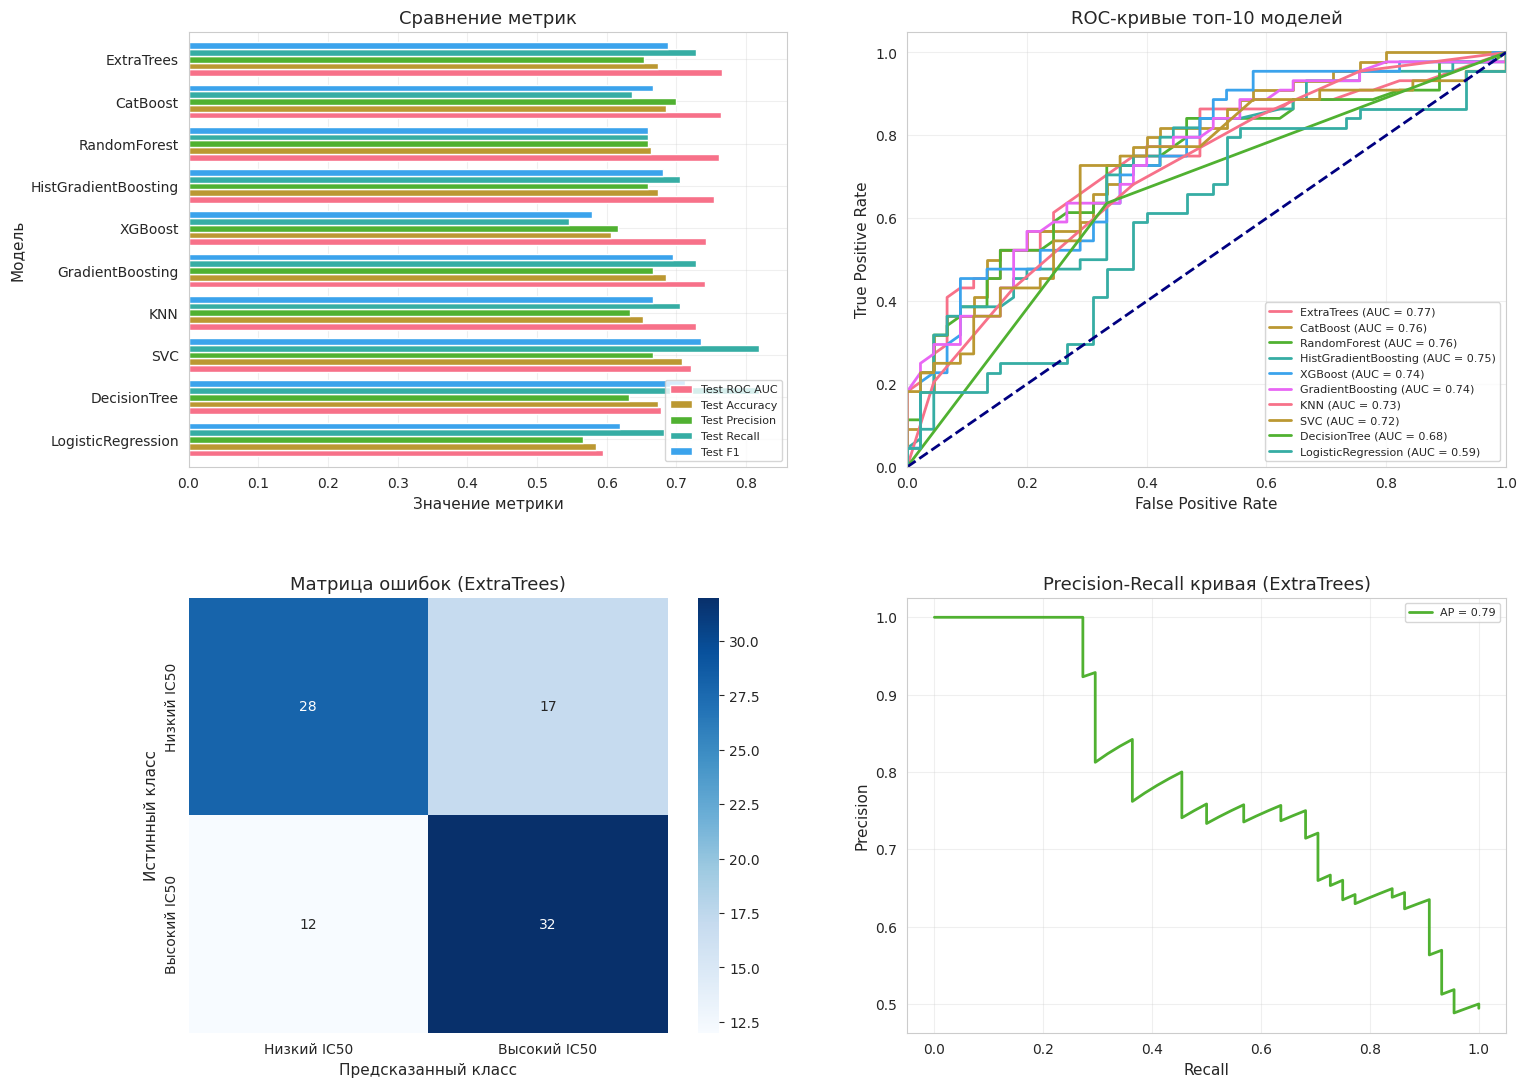

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP
# Инициализация
evaluator_umap_cleaned = ClassificationModelEvaluator(X4, y4, test_size=0.2)

# Оценка моделей
results = evaluator_umap_cleaned.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_umap_cleaned = results.copy()
results_umap_cleaned['dataframe'] = dataframe_name_4
results_umap_cleaned['metod'] = metod_name_4
columns_order = ['dataframe', 'metod'] + [col for col in results.columns]
results_umap_cleaned = results_umap_cleaned[columns_order]

# Получение лучшей модели
best_model = evaluator_umap_cleaned.get_best_model()

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_umap_cleaned.predict(X4)
predictions_umap_cleaned = predictions

# Сохраненние результата
results_umap_cleaned_id = results_umap_cleaned.reset_index()
results_umap_cleaned_id.to_csv(os.path.join(data_dir, csv_file_4), index=False)

visualizer = ClassificationResultsVisualizer(evaluator_umap_cleaned, results_df = results_umap_cleaned)
visualizer.visualize_all()

In [ ]:
results_umap_cleaned.head(5)

,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,,
ExtraTrees,cleaned_CC50,UMAP,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.746261,0.674157,0.653061,0.727273,0.688172,0.765657,"[[28, 17], [12, 32]]","{'0': {'precision': 0.7, 'recall': 0.622222222..."
CatBoost,cleaned_CC50,UMAP,"{'depth': 5, 'iterations': 100, 'l2_leaf_reg':...",0.762356,0.685393,0.700000,0.636364,0.666667,0.763889,"[[33, 12], [16, 28]]","{'0': {'precision': 0.673469387755102, 'recall..."
RandomForest,cleaned_CC50,UMAP,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.748621,0.662921,0.659091,0.659091,0.659091,0.760606,"[[30, 15], [15, 29]]","{'0': {'precision': 0.6666666666666666, 'recal..."
HistGradientBoosting,cleaned_CC50,UMAP,"{'learning_rate': 0.05, 'max_depth': 3, 'max_i...",0.735780,0.674157,0.659574,0.704545,0.681319,0.754293,"[[29, 16], [13, 31]]","{'0': {'precision': 0.6904761904761905, 'recal..."
XGBoost,cleaned_CC50,UMAP,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.747342,0.606742,0.615385,0.545455,0.578313,0.742172,"[[30, 15], [20, 24]]","{'0': {'precision': 0.6, 'recall': 0.666666666..."


# СВОД И ВЫВОДЫ

In [ ]:
# @title Датасет со всеми результатами
# Список файлов с результатами
result_files = [csv_file_1, csv_file_2, csv_file_3, csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters', 'Classification Report'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test ROC AUC', ascending=False)
combined_results_for_view.head(10)

,Model,dataframe,metod,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Data_Type
10,LogisticRegression,cleaned_CC50,PCA,0.769939,0.730337,0.738095,0.704545,0.720930,0.815909,[[34 11]\n [13 31]],pca
11,KNN,cleaned_CC50,PCA,0.785422,0.764045,0.767442,0.750000,0.758621,0.815909,[[35 10]\n [11 33]],pca
12,ExtraTrees,cleaned_CC50,PCA,0.785331,0.730337,0.763158,0.659091,0.707317,0.813384,[[36 9]\n [15 29]],pca
13,RandomForest,cleaned_CC50,PCA,0.789304,0.730337,0.750000,0.681818,0.714286,0.810354,[[35 10]\n [14 30]],pca
14,SVC,cleaned_CC50,PCA,0.790941,0.741573,0.783784,0.659091,0.716049,0.809848,[[37 8]\n [15 29]],pca
15,GradientBoosting,cleaned_CC50,PCA,0.778569,0.786517,0.804878,0.750000,0.776471,0.809343,[[37 8]\n [11 33]],pca
0,KNN,df_handmade,df_handmade,0.792762,0.764045,0.744681,0.795455,0.769231,0.807323,[[33 12]\n [ 9 35]],handmade
1,RandomForest,df_handmade,df_handmade,0.829463,0.741573,0.800000,0.636364,0.708861,0.799242,[[38 7]\n [16 28]],handmade
2,XGBoost,df_handmade,df_handmade,0.823236,0.719101,0.771429,0.613636,0.683544,0.797727,[[37 8]\n [17 27]],handmade
3,SVC,df_handmade,df_handmade,0.793608,0.707865,0.750000,0.613636,0.675000,0.794192,[[36 9]\n [17 27]],handmade


In [ ]:
combined_results

,Model,dataframe,metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report,Data_Type
0,KNN,df_handmade,df_handmade,"{'kneighborsclassifier__n_neighbors': 7, 'knei...",0.792762,0.764045,0.744681,0.795455,0.769231,0.807323,[[33 12]\n [ 9 35]],"{'0': {'precision': 0.7857142857142857, 'recal...",handmade
1,RandomForest,df_handmade,df_handmade,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.829463,0.741573,0.800000,0.636364,0.708861,0.799242,[[38 7]\n [16 28]],"{'0': {'precision': 0.7037037037037037, 'recal...",handmade
2,XGBoost,df_handmade,df_handmade,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.823236,0.719101,0.771429,0.613636,0.683544,0.797727,[[37 8]\n [17 27]],"{'0': {'precision': 0.6851851851851852, 'recal...",handmade
3,SVC,df_handmade,df_handmade,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.793608,0.707865,0.750000,0.613636,0.675000,0.794192,[[36 9]\n [17 27]],"{'0': {'precision': 0.6792452830188679, 'recal...",handmade
4,CatBoost,df_handmade,df_handmade,"{'depth': 5, 'iterations': 100, 'l2_leaf_reg':...",0.816832,0.730337,0.794118,0.613636,0.692308,0.780051,[[38 7]\n [17 27]],"{'0': {'precision': 0.6909090909090909, 'recal...",handmade
5,ExtraTrees,df_handmade,df_handmade,"{'max_depth': 20, 'min_samples_split': 10, 'n_...",0.824311,0.696629,0.717949,0.636364,0.674699,0.778535,[[34 11]\n [16 28]],"{'0': {'precision': 0.68, 'recall': 0.75555555...",handmade
6,HistGradientBoosting,df_handmade,df_handmade,"{'learning_rate': 0.05, 'max_depth': 3, 'max_i...",0.815526,0.696629,0.757576,0.568182,0.649351,0.777525,[[37 8]\n [19 25]],"{'0': {'precision': 0.6607142857142857, 'recal...",handmade
7,LogisticRegression,df_handmade,df_handmade,"{'logisticregression__C': 0.1, 'logisticregres...",0.714814,0.651685,0.658537,0.613636,0.635294,0.776010,[[31 14]\n [17 27]],"{'0': {'precision': 0.6458333333333334, 'recal...",handmade
8,GradientBoosting,df_handmade,df_handmade,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.806846,0.674157,0.702703,0.590909,0.641975,0.764394,[[34 11]\n [18 26]],"{'0': {'precision': 0.6538461538461539, 'recal...",handmade
9,DecisionTree,df_handmade,df_handmade,"{'max_depth': 5, 'min_samples_leaf': 4, 'min_s...",0.748045,0.696629,0.757576,0.568182,0.649351,0.703788,[[37 8]\n [19 25]],"{'0': {'precision': 0.6607142857142857, 'recal...",handmade


In [ ]:
value = combined_results.iloc[12, 3]
value

"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}"

In [ ]:
# @title Класс ClassificationModelEvaluatorOptuna для подбора гиперпараметров трех лучших моделей
class ClassificationModelEvaluatorOptuna:
    def __init__(self, X, y, test_size=0.2, random_state=42, n_trials=100):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.n_trials = n_trials
        self.models = {}
        self.results = None
        self.best_model = None
        self.study = None
        self.optuna_results = {}

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y,
            test_size=test_size,
            random_state=random_state,
            stratify=self.y
        )

        self._initialize_models()

    def _initialize_models(self):
        self.models = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(random_state=self.random_state, max_iter=1000)
                ),
                'params_func': self._lr_objective
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params_func': self._gb_objective
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params_func': self._rf_objective
            }
        }

    def _lr_objective(self, trial):
        # Получаем текущий пайплайн
        model = clone(self.models['LogisticRegression']['model'])

        # Параметры для оптимизации с правильным префиксом шага
        params = {
            'logisticregression__C': trial.suggest_float('C', 0.0001, 0.01, log=True),
            'logisticregression__penalty': trial.suggest_categorical('penalty', ['l2']),
            'logisticregression__solver': trial.suggest_categorical('solver', ['lbfgs']),
            'logisticregression__class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }

        # Устанавливаем параметры
        model.set_params(**params)

        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def _gb_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 250, 350),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', 25, 35),
            'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
        model = GradientBoostingClassifier(**params, random_state=self.random_state)
        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def _rf_objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 250, 350),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }
        model = RandomForestClassifier(**params, random_state=self.random_state)
        score = cross_val_score(
            model, self.X_train, self.y_train,
            cv=5, scoring='roc_auc', n_jobs=-1
        ).mean()
        return score

    def evaluate_models(self, verbose=False):
        results = []

        for name, model_info in self.models.items():
            if verbose:
                print(f"\n{'='*50}")
                print(f"Optimizing {name}...")

            # Создаем исследование Optuna
            study = optuna.create_study(direction='maximize')
            study.optimize(model_info['params_func'], n_trials=self.n_trials)

            # Сохраняем результаты исследования
            self.optuna_results[name] = study

            # Получаем лучшие параметры
            best_params = study.best_params

            # Для LogisticRegression добавляем префиксы к параметрам
            if name == 'LogisticRegression':
                prefixed_params = {'logisticregression__' + k: v for k, v in best_params.items()}
                model = model_info['model'].set_params(**prefixed_params)
            else:
                model = model_info['model'].set_params(**best_params)

            model.fit(self.X_train, self.y_train)

            if verbose:
                print(f"Best params: {best_params}")

            # Предсказания
            y_pred = model.predict(self.X_test)
            y_proba = model.predict_proba(self.X_test)[:, 1]

            # Метрики
            metrics = {
                'Model': name,
                'Best Parameters': best_params,
                'CV ROC AUC': study.best_value,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }

            results.append(metrics)

            if verbose:
                print(f"Completed: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")

            # Сохраняем лучшую модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (model, metrics['Test ROC AUC'])

        # Сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)

        return self.results

    def get_best_model(self):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        return self.best_model[0]

    def predict(self, X, return_proba=False):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

    def get_feature_importances(self):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        model = self.best_model[0]

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]
        else:
            raise ValueError("Модель не поддерживает атрибут важности признаков")

        return pd.DataFrame({
            'Feature': self.X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

    def plot_optimization_history(self, model_name):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_optimization_history(self.optuna_results[model_name])
        fig.update_layout(title=f'Optimization History for {model_name}')
        return fig

    def plot_param_importances(self, model_name):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_param_importances(self.optuna_results[model_name])
        fig.update_layout(title=f'Parameter Importances for {model_name}')
        return fig

    def plot_contour(self, model_name, params=None):
        if model_name not in self.optuna_results:
            raise ValueError(f"Нет результатов для модели {model_name}")

        fig = plot_contour(self.optuna_results[model_name], params=params)
        fig.update_layout(title=f'Contour Plot for {model_name}')
        return fig

    def plot_metrics_comparison(self):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC AUC']
        df = self.results[metrics].reset_index()

        plt.figure(figsize=(12, 6))
        df_melt = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Value')
        sns.barplot(data=df_melt, x='Metric', y='Value', hue='Model')
        plt.title('Comparison of Model Metrics')
        plt.ylim(0, 1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt.gcf()

    def plot_confusion_matrix(self, model_name):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        if model_name not in self.results.index:
            raise ValueError(f"Нет результатов для модели {model_name}")

        cm = self.results.loc[model_name, 'Confusion Matrix']
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix for {model_name}')
        return plt.gcf()

    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        """
        Сохраняет указанную модель в файл
        """
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")

        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)

        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")

            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

[I 2025-05-20 14:25:02,003] A new study created in memory with name: no-name-6789d6b1-afc6-4126-bf78-4fca8d061213



Optimizing LogisticRegression...


[I 2025-05-20 14:25:06,144] Trial 0 finished with value: 0.7688321995464853 and parameters: {'C': 0.003791120219023339, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None}. Best is trial 0 with value: 0.7688321995464853.
[I 2025-05-20 14:25:06,281] Trial 1 finished with value: 0.7693038548752835 and parameters: {'C': 0.0023766016168062514, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7693038548752835.
[I 2025-05-20 14:25:06,411] Trial 2 finished with value: 0.7705827664399093 and parameters: {'C': 0.0005505499138721615, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7705827664399093.
[I 2025-05-20 14:25:06,536] Trial 3 finished with value: 0.771390022675737 and parameters: {'C': 0.00018643212352881524, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None}. Best is trial 3 with value: 0.771390022675737.
[I 2025-05-20 14:25:06,712] Trial 4 finished with value: 0.7696122448979591 an

Best params: {'C': 0.00018643212352881524, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None}
Completed: Test ROC AUC: 0.815

Optimizing GradientBoosting...


[I 2025-05-20 14:25:20,942] Trial 0 finished with value: 0.7703877551020408 and parameters: {'n_estimators': 297, 'learning_rate': 0.056307086447494326, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.8960279048349453, 'max_features': 'log2'}. Best is trial 0 with value: 0.7703877551020408.
[I 2025-05-20 14:25:49,692] Trial 1 finished with value: 0.7661927437641723 and parameters: {'n_estimators': 301, 'learning_rate': 0.09059732837952716, 'max_depth': 34, 'min_samples_split': 13, 'min_samples_leaf': 3, 'subsample': 0.7921983635068921, 'max_features': None}. Best is trial 0 with value: 0.7703877551020408.
[I 2025-05-20 14:25:56,786] Trial 2 finished with value: 0.7789138321995465 and parameters: {'n_estimators': 270, 'learning_rate': 0.07607886901586323, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.8157626722334121, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7789138321995465.
[I 2025-05-20 14:26:02,948] Trial

Best params: {'n_estimators': 250, 'learning_rate': 0.0775696664501799, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.7246459020144508, 'max_features': 'sqrt'}
Completed: Test ROC AUC: 0.807

Optimizing RandomForest...


[I 2025-05-20 14:33:21,566] Trial 0 finished with value: 0.7726326530612245 and parameters: {'n_estimators': 263, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.7726326530612245.
[I 2025-05-20 14:33:24,797] Trial 1 finished with value: 0.7872630385487528 and parameters: {'n_estimators': 320, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.7872630385487528.
[I 2025-05-20 14:33:28,268] Trial 2 finished with value: 0.7835260770975057 and parameters: {'n_estimators': 341, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.7872630385487528.
[I 2025-05-20 14:33:31,277] Trial 3 finished with value: 0.7695578231292517 and parameters: {'n_estimators': 255, 'max_depth': 

Best params: {'n_estimators': 314, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}
Completed: Test ROC AUC: 0.809

Results:
                    Test Accuracy  Test Precision  Test Recall  Test F1  \
Model                                                                     
LogisticRegression       0.730337        0.738095     0.704545  0.72093   
RandomForest             0.730337        0.777778     0.636364  0.70000   
GradientBoosting         0.730337        0.777778     0.636364  0.70000   

                    Test ROC AUC  \
Model                              
LogisticRegression      0.814899   
RandomForest            0.809343   
GradientBoosting        0.807323   

                                                      Best Parameters  
Model                                                                  
LogisticRegression  {'C': 0.00018643212352881524, 'penalty': 'l2',...  
RandomForest        {'n

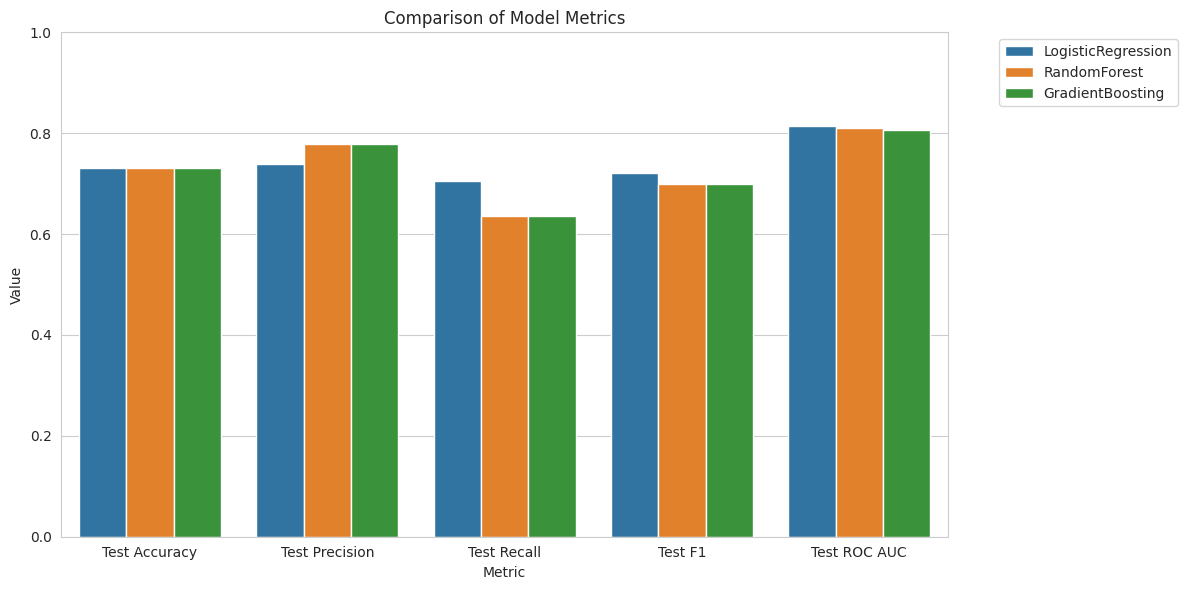

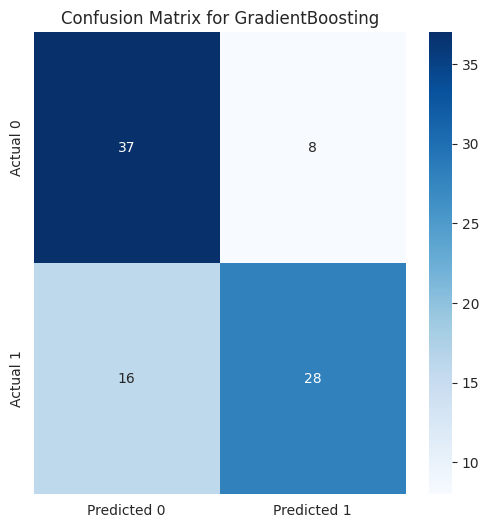

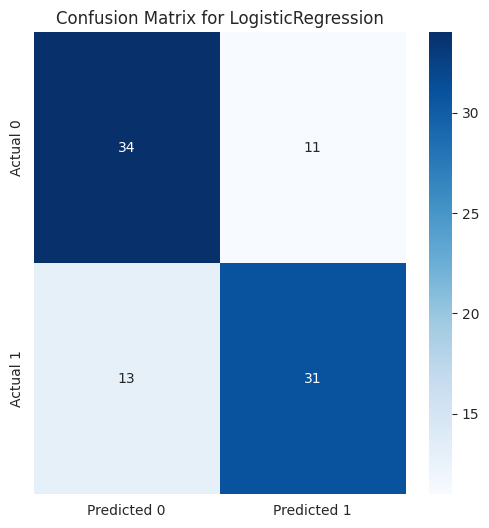

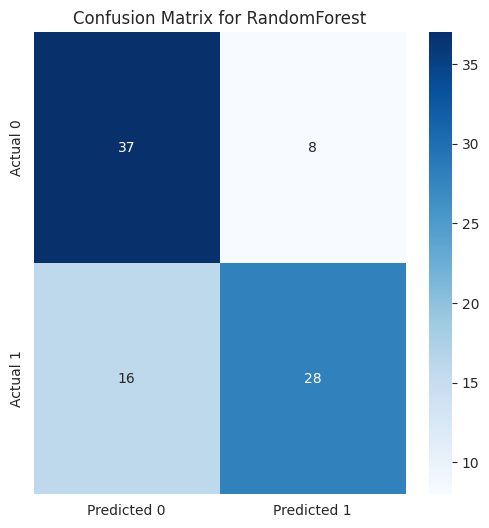

In [ ]:
# Инициализация и оценка моделей
from sklearn.base import clone
evaluator = ClassificationModelEvaluatorOptuna(X2, y2, n_trials=50)
results = evaluator.evaluate_models(verbose=True)

# Вывод результатов
print("\nResults:")
print(results[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1', 'Test ROC AUC', 'Best Parameters']])

# Визуализация результатов
evaluator.plot_metrics_comparison()
plt.show()

# Визуализация для конкретной модели (например, XGBoost)
evaluator.plot_optimization_history('GradientBoosting').show()
evaluator.plot_optimization_history('LogisticRegression').show()
evaluator.plot_optimization_history('RandomForest').show()
evaluator.plot_param_importances('GradientBoosting').show()
evaluator.plot_param_importances('LogisticRegression').show()
evaluator.plot_param_importances('RandomForest').show()
evaluator.plot_confusion_matrix('GradientBoosting')
evaluator.plot_confusion_matrix('LogisticRegression')
evaluator.plot_confusion_matrix('RandomForest')
plt.show()

In [ ]:
# @title Сохранение лучшей модели

evaluator.save_model('GradientBoosting', 'SI_class_GB_model.pkl')
evaluator.save_model('LogisticRegression', 'SI_class_LR_model.pkl')
evaluator.save_model('RandomForest', 'SI_class_RF_model.pkl')

Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class_GB_model.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class_RF_model.pkl


In [ ]:
evaluator_pca_cleaned.save_model('KNN', 'SI_class_KNN_model.pkl')

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/SI_class_KNN_model.pkl
